# Setting up PySpark enviornment

In [2]:
from pyspark import SparkContext
sc = SparkContext()

In [3]:
from pyspark import SQLContext
sqlContext = SQLContext(sc)

In [4]:
from pyspark.sql.functions import *
from pyspark.sql.types import *    

# Loading the Data
Now that the PySpark enviornment has been setup, the next step is to load in the data from Hadoop. Dataframes can be loaded using PySpark in a fashion that is similar to pandas. The variable `inferSchema` tells PySpark  to guess what the datatype of each column in the dataframe is. If the option is set to ```False``` then all columns will be loaded in as strings. We'll start with 2014 green taxi trips.

In [5]:
green_2014 = sqlContext.read.csv("hdfs://namenode:8020/am2786/***/Taxi_2014_green.csv", header=True,inferSchema=True)

In [6]:
yellow_2014 = sqlContext.read.csv("hdfs://namenode:8020/am2786/***/Taxi_2014_yellow.csv", header=True,inferSchema=True)

# Selecting only trips where credit cards were used

There is only information on how much was tipped if the trip was payed using a credit card. That being said any other type of trips have to filtered out. 

In [7]:
green_2014_credit = green_2014.filter(green_2014.Payment_type == 1)  # Selecting only trips paid via credit card

In [8]:
yellow_2014_credit = yellow_2014.filter(yellow_2014.payment_type == 'CRD') # Selecting only trips paid via credit card

# Subsampling data for XGBoost model

XGBoost models can take a while to run. To get around this we'll only look at a subsample of the datasets. For both datasets we'll choose a value of n = 100,000 trips. PySpark doesn't have a method for randomly sampling an *exact* number of rows and converting hundreds of millions of rows of data to a pandas dataframe is time-costly, so we'll take fractional subsamples using PySPark first, then convert those smaller dataframes to pandas dataframes  where the exact number of 100,000 rows can be selected.  

In [9]:
green_2014_subsample = green_2014_credit.sample(False, 0.1, seed=0) 

In [10]:
yellow_2014_subsample = yellow_2014_credit.sample(False, 0.01, seed=0)

In [11]:
green_2014_subsample_use = green_2014_subsample.toPandas()

In [12]:
yellow_2014_subsample_use = yellow_2014_subsample.toPandas()

In [13]:
green_2014_subsample_use = green_2014_subsample_use.sample(n = 100000)

In [14]:
yellow_2014_subsample_use = yellow_2014_subsample_use.sample(n = 100000)

# Cleaning data
Now it's time to clean the data. If you've looked at any of the other jupyter notebooks for this project you'll notice that this is the same `taxi_data_cleaner` function that I've written for those, except this one is done in python format as opposed to PySpark. 

In [15]:
def taxi_data_cleaner_pandas(data):
    
    data.columns = map(str.lower, data.columns)
    
    # Getting rid of rides with 0 passengers
    data = data.loc[data.passenger_count > 0]
    
    # Getting rid of rides with impossibly low fares
    data = data.loc[data.fare_amount > 1.]
    
    #Making a feature which measures the % a driver was tipped 
    data["tip_percentage"] =  100.*(data["tip_amount"])/(data["total_amount"] - data["tip_amount"])

    
    # Adding columns that give the month , day of the week and hour of pickups and dropoffs
    
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])
    
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['dropoff_hour'] = data['dropoff_datetime'].dt.hour
    data['pickup_month'] = data['pickup_datetime'].dt.month
    data['dropoff_month'] = data['dropoff_datetime'].dt.month
    data['pickup_dayofweek'] = data['pickup_datetime'].dt.dayofweek
    data['dropoff_dayofweek'] = data['dropoff_datetime'].dt.dayofweek
    

    return(data)

In [16]:
import pandas as pd
import numpy as np

Now we can run the `taxi_data_cleaner` code and set our input and target variables.

In [17]:
green_2014_subsample_use = taxi_data_cleaner_pandas(green_2014_subsample_use)
yellow_2014_subsample_use =taxi_data_cleaner_pandas(yellow_2014_subsample_use)


target_green = green_2014_subsample_use["tip_amount"]
target_yellow = yellow_2014_subsample_use["tip_amount"]

In [18]:
columns = ['pickup_dayofweek', 'pickup_month', 
           'dropoff_dayofweek', 'dropoff_month', 'dropoff_hour', 
           'tolls_amount', 'pickup_neighborhood', 'dropoff_neighborhood', 
           'passenger_count'
           ]


green_2014_subsample_use= green_2014_subsample_use[columns]
yellow_2014_subsample_use  = yellow_2014_subsample_use[columns]

# Mapping neighborhood names to integers for XGBoost model

Now we get to the part where we need to finesse a little. The columns `pickup_neighborhood` and `dropoff_neighborhood` are in string format. These need to be converted to integers. One of the many great advantages of gradient boosting models is that since we're not fitting to any particular function, there's no need for one-hot encoding. We can simply map each neighbeorhood to an individual number. 

In [19]:
neighborhoods_list = set(list(yellow_2014_subsample_use.dropoff_neighborhood.unique()) +
                         list(yellow_2014_subsample_use.pickup_neighborhood.unique())  + 
                          list(green_2014_subsample_use.pickup_neighborhood.unique())  +
                          list(green_2014_subsample_use.dropoff_neighborhood.unique()))

neighborhoods_number_list = np.arange(len(neighborhoods_list))
neighborhood_mapper = dict(zip(neighborhoods_list,neighborhoods_number_list  ))

yellow_2014_subsample_use_done = yellow_2014_subsample_use.replace({"pickup_neighborhood": neighborhood_mapper})
yellow_2014_subsample_use_done = yellow_2014_subsample_use_done.replace({"dropoff_neighborhood": neighborhood_mapper})


green_2014_subsample_use_done = green_2014_subsample_use.replace({"pickup_neighborhood": neighborhood_mapper})
green_2014_subsample_use_done = green_2014_subsample_use_done.replace({"dropoff_neighborhood": neighborhood_mapper})



Next we need to convert the target variable 'tip amount' from a continuous into a discretized form. To do this we create an array of evenly spaced tip values, then for each value in the target variable, we map it to the closest value from the evenly spaced tip value array. For example, a tip of `$1.75` gets mapped to `$2.00` if the tip value array is `python np.arange(0., 20., 2)`.

In [20]:
# This function
def feature_mapper(feature, feature_map_values):
    """
    feature: feature in question
    feature_map_values: values that the continuous values in 'feature' will be mapped to"
    """
    final = []
    for i in feature:
        i_use = feature_map_values[np.abs(feature_map_values  - i) == np.min(np.abs(feature_map_values  - i))][0]
        final.append(i_use)
    return(final)

In [21]:
target_green_binned  = feature_mapper(np.array(target_green), np.arange(0, 12., 2))
target_yellow_binned  = feature_mapper(np.array(target_yellow), np.arange(0, 12., 2))

# XGBoost modeling
Great now we can start modelling!

In [22]:
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.metrics import accuracy_score

/Users/am2786/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
X_green = green_2014_subsample_use_done
Y_green = target_green_binned 
X_train_green, X_test_green,Y_train_green, Y_test_green = train_test_split(X_green,Y_green,test_size = 0.3, random_state = 30)

In [24]:
X_yellow = yellow_2014_subsample_use_done
Y_yellow = target_yellow_binned 
X_train_yellow, X_test_yellow,Y_train_yellow, Y_test_yellow = train_test_split(X_yellow,Y_yellow,test_size = 0.3, random_state = 30)

In [25]:
model = XGBClassifier()
model.fit(X_train_green, Y_train_green)  
y_pred_green = model.predict(X_test_green) 

With the model completed a dataframe containing the feature importances of every feature can be produced for green taxis.

In [26]:
feature_importances_green = pd.DataFrame(model.feature_importances_)
feature_importances_green['feature'] = columns
feature_importances_green['importance'] = feature_importances_green[0]
feature_importances_green = feature_importances_green.drop(0, axis = 1)

The same can be done for yellow taxis.

In [27]:
model = XGBClassifier()
model.fit(X_train_yellow, Y_train_yellow)  
y_pred_yellow = model.predict(X_test_yellow)  

In [28]:
feature_importances_yellow = pd.DataFrame(model.feature_importances_)
feature_importances_yellow['feature'] = columns
feature_importances_yellow['importance'] = feature_importances_yellow[0]
feature_importances_yellow = feature_importances_yellow.drop(0, axis = 1)

# Plotting feature importances
Now let's plot.

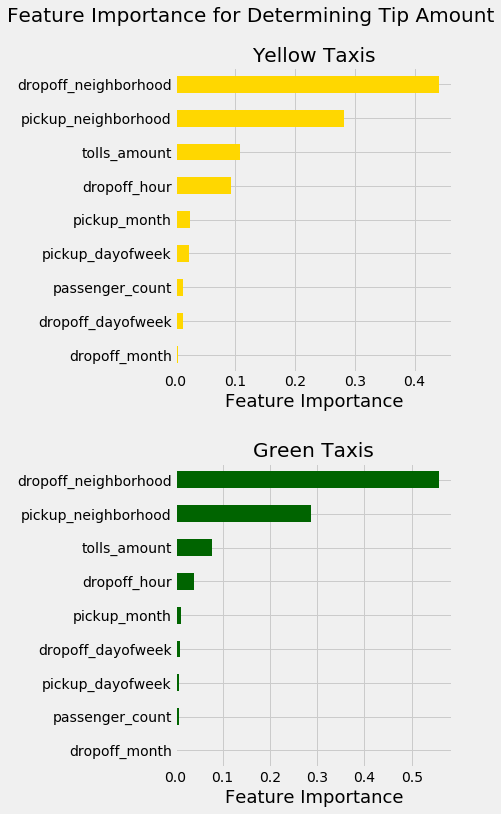

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
font_axis = 18
plt.style.use('fivethirtyeight')

plt.figure(figsize = (7,12))
plt.suptitle('Feature Importance for Determining Tip Amount', fontsize = 20)
plt.subplots_adjust(left = 0.35, right = 0.9,hspace=0.3, wspace=0.5, top = 0.91, bottom = 0.1)

ax1 = plt.subplot(211)
plt.title('Yellow Taxis')
feature_importances_yellow.sort_values(by = 'importance', ascending = False)[::-1].plot(ax = ax1, kind = 'barh', color = 'gold', legend=None)
plt.ylabel('')
plt.xlabel('Feature Importance', fontsize = font_axis)
plt.yticks(np.arange(len(feature_importances_yellow)), list(feature_importances_yellow.sort_values(by = 'importance', ascending = False)['feature'])[::-1]);



ax2 = plt.subplot(212)
plt.title('Green Taxis')
feature_importances_green.sort_values(by = 'importance', ascending = False)[::-1].plot(ax = ax2, kind = 'barh', color = 'darkgreen', legend=None)
plt.ylabel('')
plt.xlabel('Feature Importance', fontsize = font_axis)
plt.yticks(np.arange(len(feature_importances_green)), list(feature_importances_green.sort_values(by = 'importance', ascending = False)['feature'])[::-1]);

plt.savefig('Final14.png', dpi = 1000)

# Plotting error in tip amount predictions
Every output value in our test set has a corresponding predicted value. We can plot the distribution of the difference between thse two to get an idea of how well we fit the data.

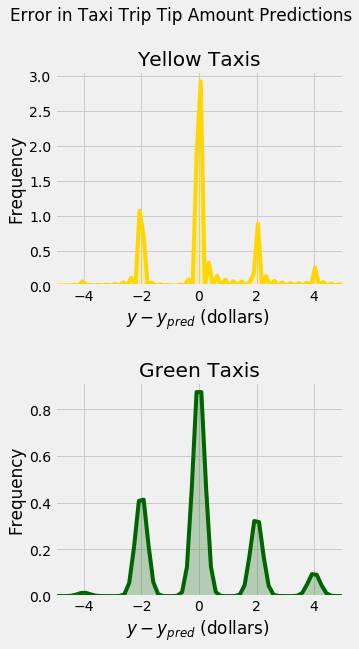

In [31]:
import seaborn as sns
tip_max = 5.

x_yellow = Y_test_yellow - y_pred_yellow
x_green = Y_test_green - y_pred_green

plt.figure(figsize = (5, 9))
plt.suptitle('Error in Taxi Trip Tip Amount Predictions')
plt.subplots_adjust(left = 0.15, hspace=0.45, wspace=0.4, top = 0.88)

ax1 = plt.subplot(211)
plt.title('Yellow Taxis')
sns.kdeplot(x_yellow, color = 'gold', shade=True)
plt.xlim(-tip_max, tip_max)
plt.xlabel(r'$y - y_{pred}$ (dollars) ')
plt.ylabel('Frequency')

ax2 = plt.subplot(212)
plt.title('Green Taxis')
sns.kdeplot(x_green, color = 'darkgreen', shade=True)
plt.xlim(-tip_max, tip_max)
plt.xlabel(r'$y - y_{pred}$ (dollars) ')
plt.ylabel('Frequency')


plt.savefig('Final13.png', dpi = 1000)

Looking at the stanbdard deviation of these distributions:

In [32]:
print (np.std(x_yellow))
print (np.std(x_green))

1.76313263732
2.06710640768
